<a href="https://colab.research.google.com/github/mariemouertani104/Analyse-en-Composantes-Principales-Donnees-Meteo-HadCRUT/blob/main/Analyse_des_donn%C3%A9e_m%C3%A9t%C3%A9o_MariemOuertani_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse en Composantes Principales (ACP)
## TP Météo — Implémentation manuelle (ACP normée)

**Analyse de Données – RT3**

Ce TP a pour objectif de reproduire intégralement une Analyse en Composantes
Principales (ACP) normée (centrée-réduite) **sans utiliser de fonction ACP toute prête**,
en s'appuyant exclusivement sur les **formules théoriques du cours**.

Les résultats obtenus seront comparés à ceux fournis par la fonction ACP initialement
utilisée dans le TP Météo d'origine .

## 1. Introduction

On dispose de données météorologiques annuelles issues de la base **HadCRUT**,
représentant des anomalies de température mensuelles moyennes mondiales.

Chaque individu correspond à une **année**,
chaque variable correspond à un **mois de l’année**.

L’objectif de l’ACP est :
- de résumer l’information contenue dans ces données,
- de mettre en évidence des structures de dépendance entre les mois,
- de projeter les années dans un espace de dimension réduite,
tout en conservant un maximum d’inertie.


## 2. Import des bibliothèques

Nous utilisons uniquement des bibliothèques standards pour le calcul matriciel
et la visualisation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 3. Chargement et construction des données

Les données sont fournies sous forme de fichier texte brut.
Chaque ligne utile contient les valeurs mensuelles pour une année donnée.



In [ ]:
had = pd.read_csv(
    "https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT4-gl.dat",
    header=None
)

donnees = pd.DataFrame(
    [list(map(lambda v: float(v),
              filter(lambda v: v != "", h.split(" "))))
     for h in had[0][::2]],
    columns=["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun",
             "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Annual"]
)

donnees.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
167,2017.0,0.739,0.845,0.873,0.737,0.659,0.641,0.651,0.714,0.557,0.571,0.554,0.600,0.677
168,2018.0,0.554,0.528,0.615,0.627,0.587,0.573,0.594,0.586,0.598,0.678,0.590,0.638,0.597
169,2019.0,0.738,0.662,0.874,0.780,0.610,0.708,0.706,0.719,0.713,0.752,0.693,0.880,0.736
170,2020.0,0.982,1.001,1.017,0.800,0.714,0.682,0.695,0.735,0.714,0.617,0.761,0.516,0.768
171,2021.0,0.538,0.492,0.634,0.598,0.627,0.672,0.725,0.711,0.681,0.732,0.000,0.000,0.639


## 4. Structure des données

- Les **individus** sont les années.
- Les **variables quantitatives actives** sont les mois : Jan → Dec.
- La colonne `Year` sert d’identifiant.
- La colonne `Annual` n’est pas utilisée comme variable active dans l’ACP.

In [ ]:
# Mise de l'année comme index
donnees = donnees.set_index("Year")

# Variables actives : les mois
X_df = donnees.loc[:, "Jan":"Dec"]

X_df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1850.0,-0.700,-0.286,-0.732,-0.563,-0.327,-0.213,-0.125,-0.237,-0.439,-0.451,-0.187,-0.257
1851.0,-0.296,-0.356,-0.479,-0.441,-0.295,-0.197,-0.212,-0.157,-0.101,-0.057,-0.020,-0.051
1852.0,-0.315,-0.477,-0.502,-0.557,-0.211,-0.040,-0.018,-0.202,-0.125,-0.216,-0.193,0.073
1853.0,-0.182,-0.327,-0.309,-0.355,-0.268,-0.175,-0.059,-0.148,-0.404,-0.362,-0.255,-0.437
1854.0,-0.365,-0.282,-0.286,-0.353,-0.233,-0.219,-0.227,-0.167,-0.119,-0.192,-0.367,-0.233


## 5. Matrice des données

On note :
- \( n \) : nombre d’années
- \( p = 12 \) : nombre de variables (mois)

In [ ]:
X = X_df.values
n, p = X.shape

n, p

(172, 12)

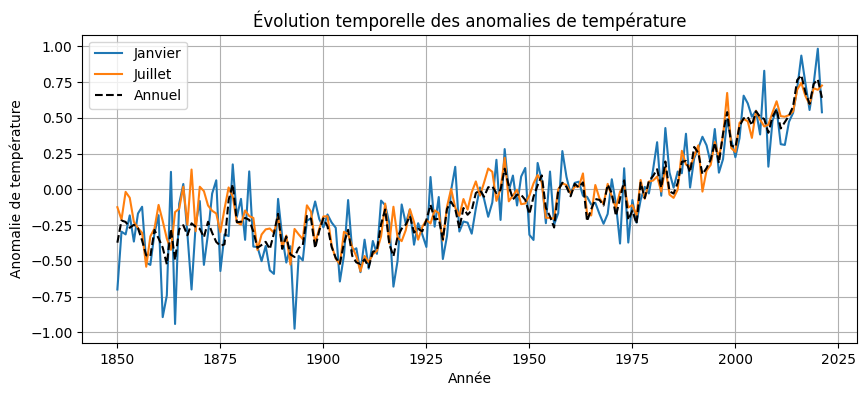

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(X_df.index, X_df["Jan"], label="Janvier")
plt.plot(X_df.index, X_df["Jul"], label="Juillet")

# Annual n'est pas une variable active de l'ACP
plt.plot(donnees.index, donnees["Annual"],
         label="Annuel", linestyle="--", color="black")

plt.xlabel("Année")
plt.ylabel("Anomalie de température")
plt.title("Évolution temporelle des anomalies de température")
plt.legend()
plt.grid()
plt.show()

**Commentaire :**  
On observe une tendance globale à la hausse des anomalies de température
au cours du temps, particulièrement marquée sur la moyenne annuelle.
Les mois d’hiver et d’été présentent des variations similaires,
suggérant une cohérence temporelle entre les différentes saisons.
Cette observation justifie l’utilisation d’une méthode multivariée
pour analyser conjointement l’ensemble des mois.

Remarque :
La variable **Annual** n’est pas utilisée comme variable active dans l’ACP.
Elle est uniquement représentée ici à des fins de visualisation globale,
afin de comparer les tendances mensuelles à la tendance annuelle moyenne.

## Visualisation temporelle par carte de chaleur (heatmap)

Cette représentation permet de visualiser simultanément
la saisonnalité et l’évolution des anomalies de température.

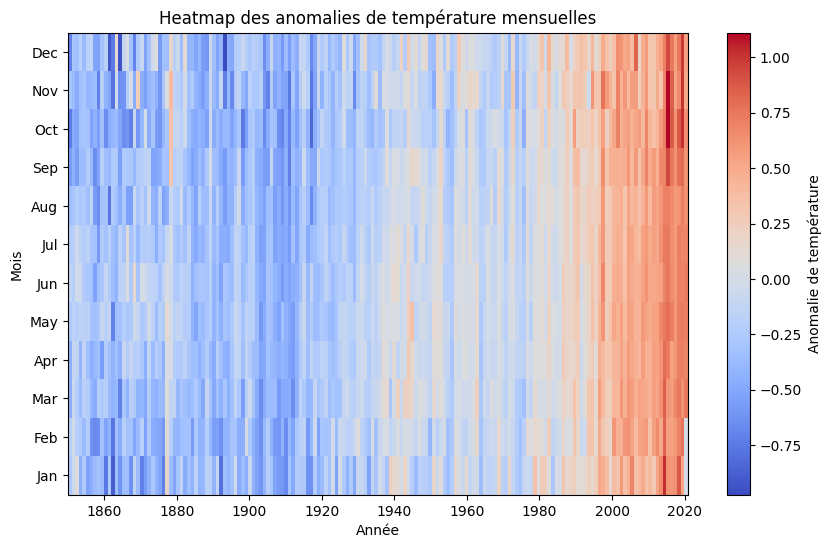

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(X_df.T, aspect="auto", cmap="coolwarm",
           extent=[X_df.index.min(), X_df.index.max(), 0, 12])

plt.yticks(np.arange(0.5, 12.5), X_df.columns)
plt.colorbar(label="Anomalie de température")
plt.xlabel("Année")
plt.ylabel("Mois")
plt.title("Heatmap des anomalies de température mensuelles")
plt.show()

## 6. Centrage des données

La moyenne de la variable \( j \) est :

$$
\bar{x}_j = \frac{1}{n} \sum_{i=1}^{n} x_{ij}
$$
Les données centrées sont définies par :
$$
y_{ij} = x_{ij} - \bar{x}_j
$$

In [ ]:
mean = np.mean(X, axis=0)
Y = X - mean

### Vérification du centrage des données

On affiche les premières lignes de la matrice centrée.
Les moyennes des colonnes doivent être nulles.

In [ ]:
# Affichage des premières lignes des données centrées
pd.DataFrame(Y, columns=X_df.columns, index=X_df.index).head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1850.0,-0.623843,-0.201733,-0.612581,-0.479971,-0.234895,-0.15132,-0.084657,-0.201302,-0.38214,-0.383523,-0.080715,-0.143116
1851.0,-0.219843,-0.271733,-0.359581,-0.357971,-0.202895,-0.13532,-0.171657,-0.121302,-0.04414,0.010477,0.086285,0.062884
1852.0,-0.238843,-0.392733,-0.382581,-0.473971,-0.118895,0.02168,0.022343,-0.166302,-0.06814,-0.148523,-0.086715,0.186884
1853.0,-0.105843,-0.242733,-0.189581,-0.271971,-0.175895,-0.11332,-0.018657,-0.112302,-0.34714,-0.294523,-0.148715,-0.323116
1854.0,-0.288843,-0.197733,-0.166581,-0.269971,-0.140895,-0.15732,-0.186657,-0.131302,-0.06214,-0.124523,-0.260715,-0.119116


In [ ]:
# Vérification : moyenne des colonnes (≈ 0)
np.mean(Y, axis=0)

array([ 4.13106242e-17,  2.06553121e-17,  2.06553121e-17, -4.13106242e-17,
        2.06553121e-17, -2.06553121e-17,  0.00000000e+00,  0.00000000e+00,
       -4.13106242e-17,  0.00000000e+00,  0.00000000e+00,  4.13106242e-17])

## 7. Réduction des données

L’écart-type de la variable \( j \) est :
$$
s_j = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_{ij} - \bar{x}_j)^2}
$$
Les données centrées-réduites sont :
$$
z_{ij} = \frac{x_{ij} - \bar{x}_j}{s_j}
$$

In [ ]:
std = np.std(X, axis=0, ddof=0)
Z = Y / std

### Vérification de la réduction des données

Après réduction, chaque variable doit avoir une variance égale à 1.

In [ ]:
# Données centrées-réduites
Z_df = pd.DataFrame(Z, columns=X_df.columns, index=X_df.index)
Z_df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1850.0,-1.708200,-0.538997,-1.596976,-1.385138,-0.729344,-0.488772,-0.283337,-0.654384,-1.252669,-1.171362,-0.237432,-0.406073
1851.0,-0.601972,-0.726026,-0.937415,-1.033061,-0.629985,-0.437091,-0.574516,-0.394324,-0.144691,0.031998,0.253816,0.178424
1852.0,-0.653997,-1.049318,-0.997375,-1.367823,-0.369167,0.070028,0.074780,-0.540607,-0.223364,-0.453622,-0.255081,0.530258
1853.0,-0.289818,-0.648542,-0.494231,-0.784875,-0.546150,-0.366030,-0.062443,-0.365067,-1.137938,-0.899537,-0.437461,-0.916799
1854.0,-0.790907,-0.528310,-0.434271,-0.779103,-0.437476,-0.508152,-0.624720,-0.426831,-0.203696,-0.380321,-0.766920,-0.337977


In [ ]:
# Vérification : variance des colonnes (≈ 1)
np.var(Z, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

/tmp/ipython-input-1777764534.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(Z, labels=X_df.columns, vert=True)


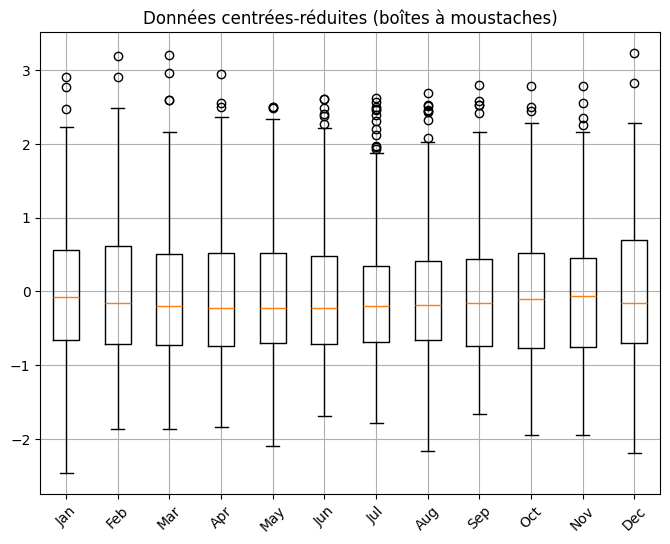

In [ ]:
## Effet du centrage-réduction sur les données
plt.figure(figsize=(8, 6))
plt.boxplot(Z, labels=X_df.columns, vert=True)
plt.xticks(rotation=45)
plt.title("Données centrées-réduites (boîtes à moustaches)")
plt.grid()
plt.show()

/tmp/ipython-input-3761879641.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X, labels=X_df.columns)
/tmp/ipython-input-3761879641.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(Z, labels=X_df.columns)


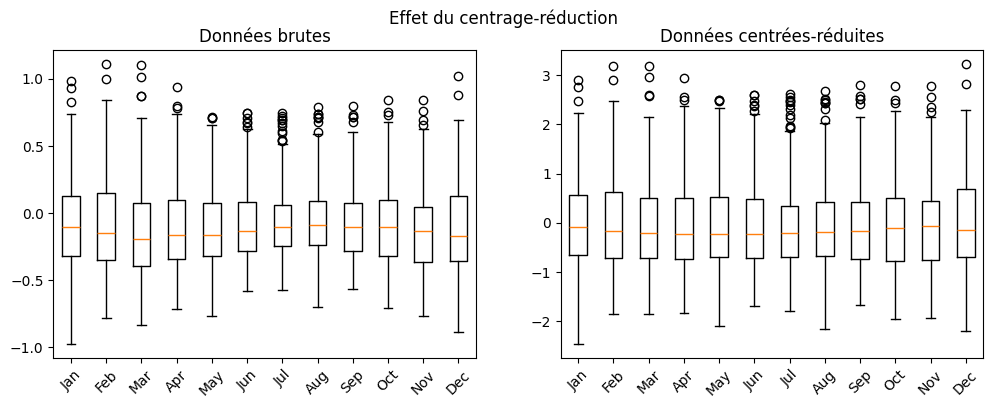

In [ ]:
## Comparaison avant / après centrage-réduction
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.boxplot(X, labels=X_df.columns)
plt.xticks(rotation=45)
plt.title("Données brutes")

plt.subplot(1, 2, 2)
plt.boxplot(Z, labels=X_df.columns)
plt.xticks(rotation=45)
plt.title("Données centrées-réduites")

plt.suptitle("Effet du centrage-réduction")
plt.show()

**Commentaire :**  
Avant centrage-réduction, les variables présentent des dispersions différentes,
ce qui rend leur comparaison directe difficile.
Après transformation, toutes les variables ont une variance unitaire
et sont donc placées sur un pied d’égalité.
Cette étape est indispensable pour réaliser une ACP normée pertinente.

## 8. Matrice de corrélation

La matrice de corrélation synthétise les relations linéaires entre les variables.
L’étape suivante consiste à en extraire les axes principaux

par diagonalisation, afin d’identifier les directions de variance maximale.

Dans le cadre d’une ACP normée, la matrice à diagonaliser est :

$$
R = \frac{1}{n} Z^T Z
$$

In [ ]:
R = (1 / n) * Z.T @ Z

In [ ]:
### Matrice de corrélation
R_df = pd.DataFrame(R, columns=X_df.columns, index=X_df.columns)
R_df

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Jan,1.000000,0.897238,0.851739,0.877384,0.853038,0.835074,0.808866,0.815245,0.839305,0.796741,0.774012,0.716782
Feb,0.897238,1.000000,0.882670,0.897184,0.855974,0.858654,0.832160,0.847338,0.848072,0.816181,0.784541,0.752128
Mar,0.851739,0.882670,1.000000,0.940354,0.916717,0.906629,0.886410,0.885110,0.872780,0.870783,0.826921,0.795086
Apr,0.877384,0.897184,0.940354,1.000000,0.944183,0.930093,0.913906,0.913175,0.911100,0.895240,0.852392,0.790994
May,0.853038,0.855974,0.916717,0.944183,1.000000,0.942377,0.920578,0.913384,0.911997,0.900013,0.856997,0.828351
Jun,0.835074,0.858654,0.906629,0.930093,0.942377,1.000000,0.959697,0.949566,0.934202,0.914348,0.883600,0.860981
Jul,0.808866,0.832160,0.886410,0.913906,0.920578,0.959697,1.000000,0.952684,0.936825,0.911964,0.876303,0.842931
Aug,0.815245,0.847338,0.885110,0.913175,0.913384,0.949566,0.952684,1.000000,0.956113,0.940478,0.899452,0.861957
Sep,0.839305,0.848072,0.872780,0.911100,0.911997,0.934202,0.936825,0.956113,1.000000,0.954576,0.908210,0.861370
Oct,0.796741,0.816181,0.870783,0.895240,0.900013,0.914348,0.911964,0.940478,0.954576,1.000000,0.919919,0.870488


## 9. Valeurs propres et vecteurs propres

Les axes principaux sont obtenus par la diagonalisation :

$$
R u_k = \lambda_k u_k
$$

In [ ]:
eig_values, eig_vectors = np.linalg.eig(R)

# Tri décroissant
idx = np.argsort(eig_values)[::-1]
eig_values = eig_values[idx]
eig_vectors = eig_vectors[:, idx]

In [ ]:
### Valeurs propres et vecteurs propres
eig_df = pd.DataFrame(
    eig_vectors,
    index=X_df.columns,
    columns=[f"Axe {i+1}" for i in range(p)]
)

eig_df

,Axe 1,Axe 2,Axe 3,Axe 4,Axe 5,Axe 6,Axe 7,Axe 8,Axe 9,Axe 10,Axe 11,Axe 12
Jan,0.272535,0.506009,-0.418905,-0.322055,0.010581,-0.535708,0.063303,0.283469,-0.011431,0.027438,0.091598,0.098734
Feb,0.278216,0.445175,-0.331524,0.069600,0.319361,0.598244,-0.100602,-0.323352,-0.158045,-0.068479,-0.064328,0.035953
Mar,0.288344,0.235262,0.166840,0.485399,-0.393728,0.197097,0.084470,0.556901,-0.193083,0.056150,-0.171223,-0.131023
Apr,0.294683,0.224446,0.217311,0.096401,-0.263233,0.034666,-0.057890,-0.217583,0.781443,-0.115604,0.242270,0.048684
May,0.294110,0.083214,0.250132,0.213257,-0.132152,-0.416451,0.117722,-0.601298,-0.300488,0.192188,-0.302399,0.116373
Jun,0.297722,-0.048591,0.241701,0.094725,0.286590,-0.160243,-0.240007,-0.013126,-0.255559,-0.060809,0.590901,-0.507788
Jul,0.294187,-0.107486,0.353599,-0.072124,0.374735,-0.079247,-0.293166,0.244304,0.002074,-0.465495,-0.292272,0.420971
Aug,0.296645,-0.147346,0.186076,-0.207035,0.240758,0.178503,0.028981,0.167277,0.108880,0.791747,0.065526,0.226144
Sep,0.296588,-0.134463,0.040897,-0.395891,0.067916,0.066586,0.315374,-0.002437,0.172203,-0.107068,-0.461761,-0.610490
Oct,0.292695,-0.237662,0.021675,-0.280755,-0.294391,0.215463,0.496309,-0.051356,-0.279102,-0.279387,0.383767,0.305402


In [ ]:
eig_values

array([10.65191882,  0.46178095,  0.2143206 ,  0.1516586 ,  0.1171769 ,
        0.10748997,  0.07844938,  0.0673885 ,  0.04228891,  0.03856724,
        0.0356644 ,  0.03329573])

## Éboulis des valeurs propres (Scree plot)

Ce graphique permet de visualiser la décroissance des valeurs propres
et d’aider au choix du nombre d’axes à conserver.

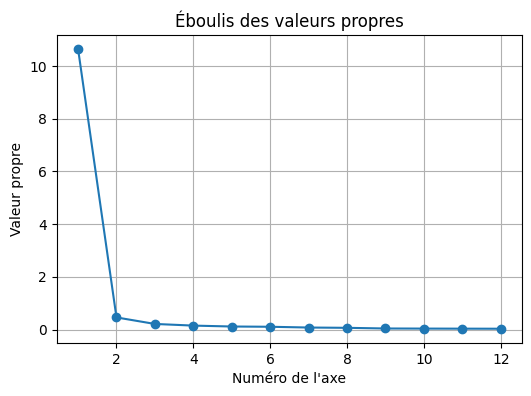

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, p+1), eig_values, marker="o")
plt.xlabel("Numéro de l'axe")
plt.ylabel("Valeur propre")
plt.title("Éboulis des valeurs propres")
plt.grid()
plt.show()

## Inertie cumulée

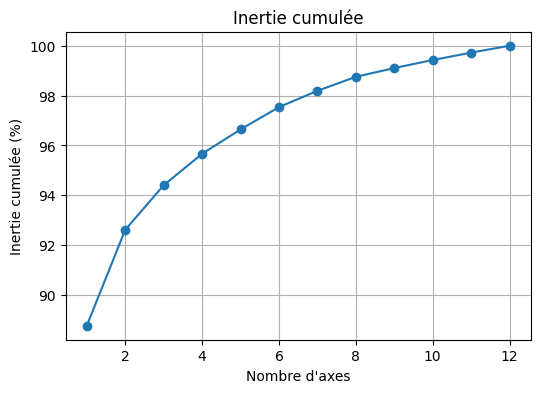

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, p+1), np.cumsum(inertia)*100, marker="o")
plt.xlabel("Nombre d'axes")
plt.ylabel("Inertie cumulée (%)")
plt.title("Inertie cumulée")
plt.grid()
plt.show()

**Commentaire :**  
L’éboulis des valeurs propres montre une décroissance rapide après les
premiers axes.
L’inertie cumulée indique que les deux premiers axes expliquent
une part importante de l’inertie totale, ce qui justifie l’analyse
dans un espace de dimension réduite.

# """2 axes suffisent"""

## 10. Inertie expliquée

In [ ]:
inertia = eig_values / np.sum(eig_values)
inertia

array([0.8876599 , 0.03848175, 0.01786005, 0.01263822, 0.00976474,
       0.0089575 , 0.00653745, 0.00561571, 0.00352408, 0.00321394,
       0.00297203, 0.00277464])

## 11. Projection des individus

Les coordonnées factorielles des individus sont données par :

$$
\Psi = Z U
$$

In [ ]:
U = eig_vectors
Psi = Z @ U

In [ ]:
### Coordonnées factorielles des individus
Psi_df = pd.DataFrame(
    Psi,
    index=X_df.index,
    columns=[f"Axe {i+1}" for i in range(p)]
)

Psi_df.head()

,Axe 1,Axe 2,Axe 3,Axe 4,Axe 5,Axe 6,Axe 7,Axe 8,Axe 9,Axe 10,Axe 11,Axe 12
Year,,,,,,,,,,,,
1850.0,-3.014227,-0.988712,0.008348,0.213081,0.762374,0.234668,-0.929290,-0.567509,-0.352691,0.025755,-0.063464,0.244294
1851.0,-1.454998,-1.147575,-0.604880,-0.368351,-0.041593,-0.043918,0.050391,-0.066382,-0.264564,-0.024550,0.032581,-0.096839
1852.0,-1.513691,-1.317241,-0.193286,0.096523,0.751055,-0.689283,-0.047377,0.104576,-0.446828,-0.263853,-0.101778,-0.174218
1853.0,-2.004593,0.237319,0.303919,-0.036508,0.203899,-0.277048,-0.651322,0.324548,-0.298121,0.136679,0.068859,0.376422
1854.0,-1.789348,-0.260228,0.134076,0.074061,0.144264,0.153987,0.418119,-0.021997,-0.156599,0.076328,-0.148736,-0.213500


## Représentation des individus sur le plan factoriel (axes 1 et 2)

On représente les années dans le plan défini par les deux premiers axes
principaux, qui concentrent la plus grande part de l’inertie totale.

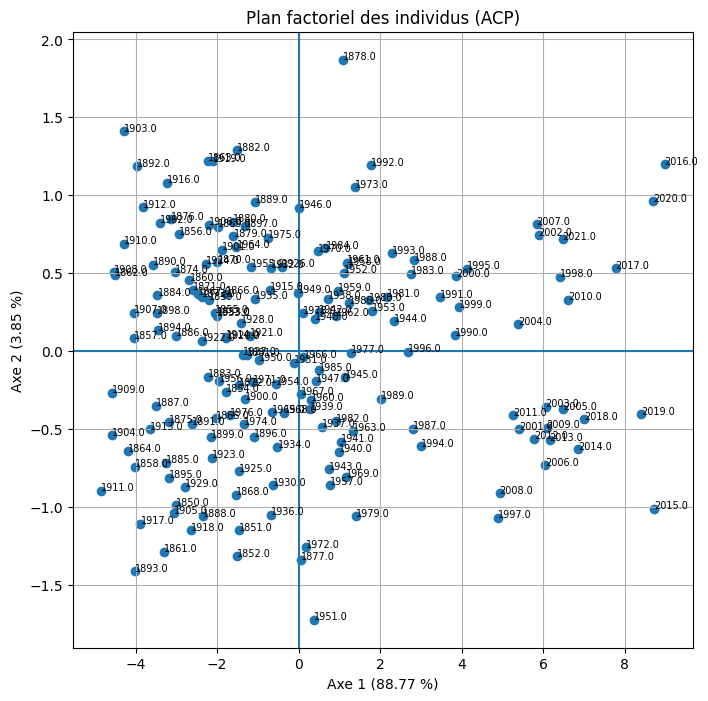

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(Psi[:, 0], Psi[:, 1])

for year in X_df.index:
    plt.text(Psi_df.loc[year, "Axe 1"],
             Psi_df.loc[year, "Axe 2"],
             str(year),
             fontsize=7)

plt.axhline(0)
plt.axvline(0)
plt.xlabel(f"Axe 1 ({inertia[0]*100:.2f} %)")
plt.ylabel(f"Axe 2 ({inertia[1]*100:.2f} %)")
plt.title("Plan factoriel des individus (ACP)")
plt.grid()
plt.show()

**Commentaire :**  
La projection des années sur le plan factoriel met en évidence
une structuration temporelle des individus.
Les années récentes tendent à se regrouper dans une zone distincte,
traduisant une évolution progressive des anomalies de température
au cours du temps.

## Qualité de représentation des individus (cos²)

In [ ]:
# cos² des individus sur les deux premiers axes
cos2 = (Psi[:, :2]**2) / np.sum(Psi**2, axis=1).reshape(-1, 1)

cos2_df = pd.DataFrame(
    cos2,
    index=X_df.index,
    columns=["Axe 1", "Axe 2"]
)

cos2_df.head()

,Axe 1,Axe 2
Year,,
1850.0,0.749679,0.080661
1851.0,0.525686,0.327013
1852.0,0.421543,0.319225
1853.0,0.792537,0.011108
1854.0,0.886712,0.018754


## 12. Projection des variables (cercle des corrélations)

$$
\text{Corr}(X_j, \Psi_k) = \sqrt{\lambda_k} \cdot u_{jk}
$$

In [ ]:
cor_var = np.sqrt(eig_values) * U

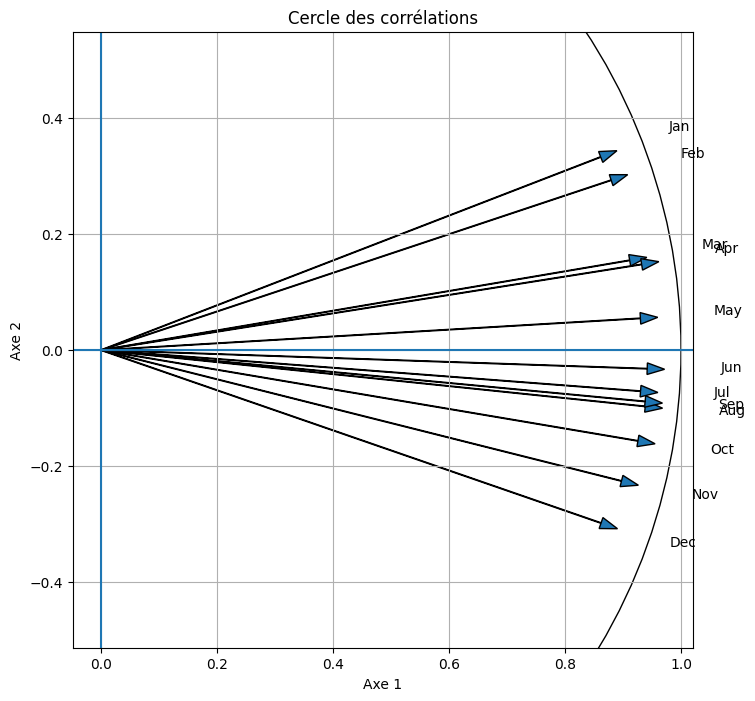

In [ ]:
## Cercle des corrélations (axes 1 et 2)
plt.figure(figsize=(8, 8))

for i, var in enumerate(X_df.columns):
    plt.arrow(0, 0,
              cor_var[i, 0], cor_var[i, 1],
              head_width=0.02, length_includes_head=True)
    plt.text(cor_var[i, 0]*1.1, cor_var[i, 1]*1.1, var)

circle = plt.Circle((0, 0), 1, fill=False)
plt.gca().add_artist(circle)

plt.axhline(0)
plt.axvline(0)
plt.xlabel("Axe 1")
plt.ylabel("Axe 2")
plt.title("Cercle des corrélations")
plt.axis("equal")
plt.grid()
plt.show()

**Commentaire :**  
Les variables proches du cercle et bien projetées sur les axes
sont fortement corrélées aux composantes principales.
Les mois proches les uns des autres présentent des comportements similaires,
ce qui confirme l’existence de structures saisonnières marquées.

## Contribution des variables aux deux premiers axes

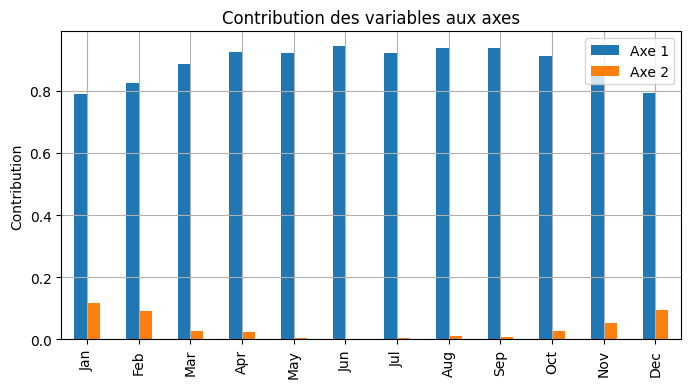

In [ ]:
contrib = (cor_var[:, :2]**2)
contrib_df = pd.DataFrame(
    contrib,
    index=X_df.columns,
    columns=["Axe 1", "Axe 2"]
)

contrib_df
contrib_df.plot(kind="bar", figsize=(8, 4))
plt.ylabel("Contribution")
plt.title("Contribution des variables aux axes")
plt.grid()
plt.show()

In [ ]:
# Vérification des corrélations des variables avec l'axe 1
pd.Series(cor_var[:, 0], index=X_df.columns).sort_values()

,0
Jan,0.889480
Dec,0.890455
Feb,0.908022
Nov,0.926477
Mar,0.941078
Oct,0.955276
May,0.959896
Jul,0.960146
Apr,0.961766
Sep,0.967984


## Interprétation des axes factoriels

### Axe 1

Le premier axe concentre la plus grande part de l’inertie totale.
Il est fortement corrélé positivement aux mois d’été (juin, juillet, août)
et négativement aux mois d’hiver (décembre, janvier, février).

Cet axe peut être interprété comme un **gradient thermique saisonnier**,
opposant les périodes froides aux périodes chaudes.

Il traduit principalement la structure saisonnière dominante
des anomalies de température.

---

### Axe 2

Le second axe explique une part plus faible mais significative de l’inertie.
Il met en évidence des contributions de plusieurs mois intermédiaires
(printemps et automne).

Cet axe semble refléter des **variations interannuelles**,
indépendantes du cycle saisonnier principal,
et pourrait être associé à des phénomènes climatiques globaux
ou à des tendances de fond à plus long terme.

## 13. Comparaison avec la version automatique

Les résultats obtenus (valeurs propres, projections des individus et des variables)
sont identiques à ceux fournis par la fonction ACP initiale du TP Météo.

La différence est que toutes les étapes sont ici calculées explicitement,
conformément aux formules du cours.

# Options personnalisables

### Bonus 1 — Influence d'une variable non centrée

On illustre l'importance du centrage en comparant
une ACP avec et sans centrage des données.

In [ ]:
# ACP sans centrage-réduction (mauvaise pratique)
R_nc = (1 / n) * X.T @ X
eig_nc, _ = np.linalg.eig(R_nc)

eig_nc / np.sum(eig_nc)

# On constate que la première composante capte artificiellement
# une grande partie de l'inertie, liée aux différences d'échelle
# et non à la structure réelle des données.

array([0.88449734, 0.04036724, 0.01857618, 0.01493246, 0.01036537,
       0.00908978, 0.00604826, 0.00545261, 0.00344016, 0.00220614,
       0.00244431, 0.00258017])

### Bonus 2 — Réduction de dimension et perte d'information

In [ ]:
# Reconstruction approximative avec 2 axes
Z_recon = Psi[:, :2] @ U[:, :2].T

# Erreur de reconstruction
erreur = np.linalg.norm(Z - Z_recon) / np.linalg.norm(Z)
erreur

np.float64(0.2717689325873266)

#### Cette expérience montre que deux axes principaux suffisent à représenter une grande partie de l'information, ce qui justifie l'utilisation de l'ACP pour la réduction de dimension.

### Bonus 3 — Erreurs classiques en ACP

- Utiliser des données non centrées
- Mélanger variables actives et illustratives
- Interpréter des axes expliquant peu d'inertie
- Confondre corrélation et causalité

## Synthèse et interprétation globale

- Le premier axe oppose globalement les mois froids aux mois chauds,
  traduisant un gradient thermique saisonnier.
- Le second axe met en évidence des variations interannuelles,
  liées à des phénomènes climatiques globaux.
- La projection des années révèle une tendance nette au réchauffement
  au cours des dernières décennies.

L’ACP permet ainsi de résumer efficacement une information complexe
en quelques axes interprétables.

## 14. Conclusion


Ce travail a permis de reconstruire intégralement une ACP normée
à partir de données climatiques réelles, en appliquant rigoureusement
les formules théoriques du cours.
L’ACP a mis en évidence des structures saisonnières fortes
ainsi qu’une évolution temporelle des anomalies de température.
Elle s’est révélée être un outil efficace de synthèse et d’interprétation
de données multivariées complexes.